# Imports

In [1]:
from src.convolution.numerical import convolution
from src.spectrum import (
    LinealEnergySpectrum,
    SpectrumData,
    SpectrumValueType,
    SpecificEnergySpectrum,
    specific_energy_spectum,
    lineal_energy_spectum,
)
from src.paths import project_dir

In [42]:
import numpy as np
import matplotlib

%matplotlib inline
import matplotlib.pylab as plt
from tqdm import tqdm

In [43]:
!python -V

Python 3.9.8


# Single event spectra for Cs137 (d=1um)

## f1 y spectrum

In [44]:
spectrum_y_f1 = LinealEnergySpectrum.from_csv(
    project_dir / "data" / "interim" / "Cs137_ydy.csv",
    delimiter="\t",
    value_type=SpectrumValueType.ydy,
)
spectrum_y_f1.norm

1.0

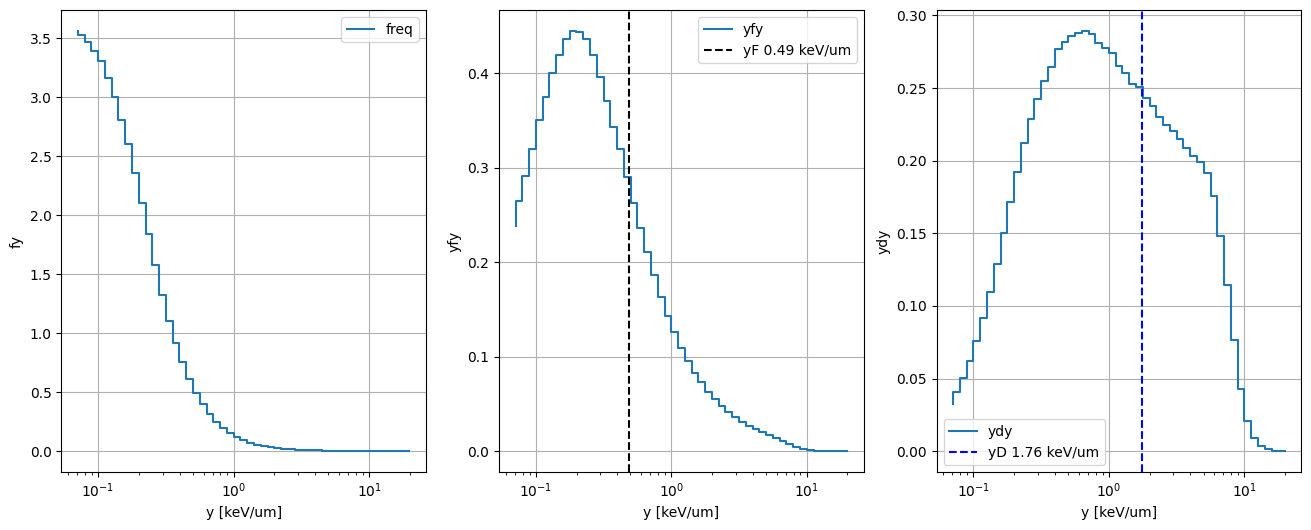

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="freq",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label="yfy",
)
ax[1].axvline(
    spectrum_y_f1.yF,
    color="k",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label="ydy",
)
ax[2].axvline(
    spectrum_y_f1.yD,
    color="b",
    linestyle="--",
    label=f"yD {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f1 z spectrum

In [46]:
site_diam_um = 1.0
spectrum_z_f1 = specific_energy_spectum(spectrum_y_f1, site_diam_um=site_diam_um)

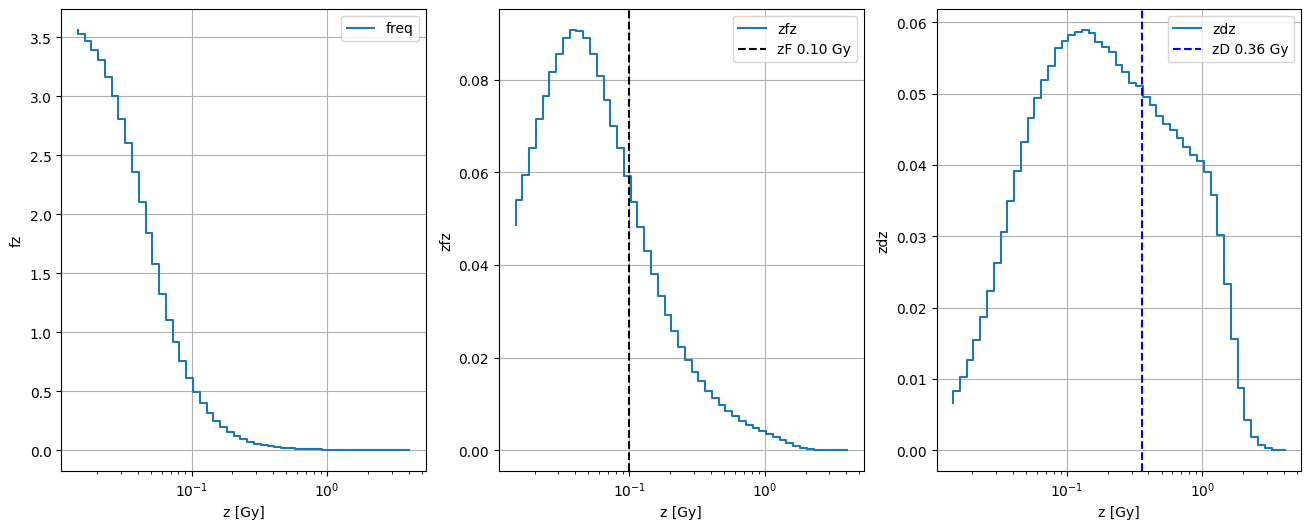

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.fz,
    label="freq",
)
ax[0].set_ylabel("fz")
ax[1].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zfz,
    label="zfz",
)
ax[1].axvline(
    spectrum_z_f1.zF,
    color="k",
    linestyle="--",
    label=f"zF {spectrum_z_f1.zF:2.2f} Gy",
)
ax[1].set_ylabel("zfz")
ax[2].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zdz,
    label="zdz",
)
ax[2].axvline(
    spectrum_z_f1.zD,
    color="b",
    linestyle="--",
    label=f"zD {spectrum_z_f1.zD:2.2f} Gy",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

## convolution f1*f1 for y

In [49]:
# we apply convolution on f(y), not on yfy or ydy
spectrum_y_f1_function = lambda x: spectrum_y_f1.data.bin_value(
    x, spectrum_value_type=SpectrumValueType.fy
)

expected_f2_domain = (
    spectrum_y_f1.data.bin_edges[0] * 2,
    spectrum_y_f1.data.bin_edges[-1] * 2.0,
)
yvalues_for_f2_convolution = np.geomspace(
    start=expected_f2_domain[0], stop=expected_f2_domain[1], num=50
)

convolution_integration_limits = (
    spectrum_y_f1.data.bin_edges[0] / 8,
    spectrum_y_f1.data.bin_edges[-1] * 8,
)
integral_kwargs = {
    "limit": 800,
    "points": np.geomspace(*convolution_integration_limits, 400),
}
spectrum_y_f2_values_and_errors = [
    convolution(
        spectrum_y_f1_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in tqdm(yvalues_for_f2_convolution)
]

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


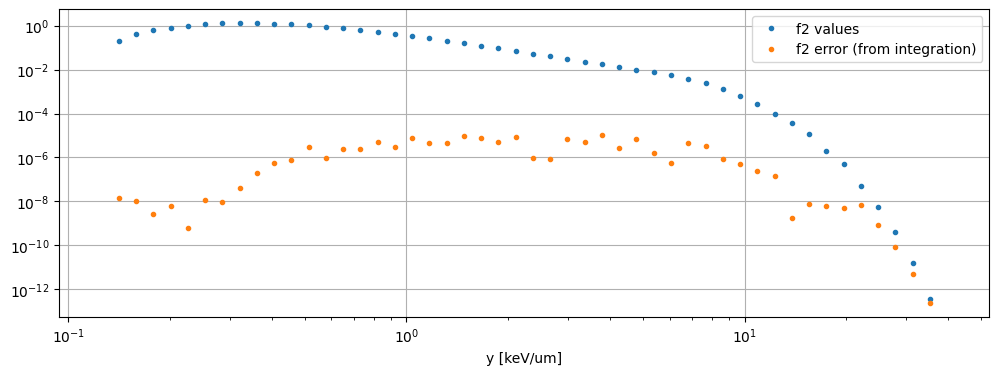

In [50]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(
    yvalues_for_f2_convolution,
    [item[0] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 values",
)
ax.plot(
    yvalues_for_f2_convolution,
    [item[1] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 error (from integration)",
)
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## f2 y spectrum

In [51]:
spectrum_y_f2 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=yvalues_for_f2_convolution,
        bin_values_freq=np.array([item[0] for item in spectrum_y_f2_values_and_errors]),
    )
)

In [52]:
spectrum_y_f2.yF, spectrum_y_f2.yD

(0.9750110341393071, 2.2420793595133737)

In [53]:
# check if yF is doubled
spectrum_y_f2.yF / spectrum_y_f1.yF

1.997274140355387

In [54]:
# check norm
spectrum_y_f2.norm

0.9998217528185123

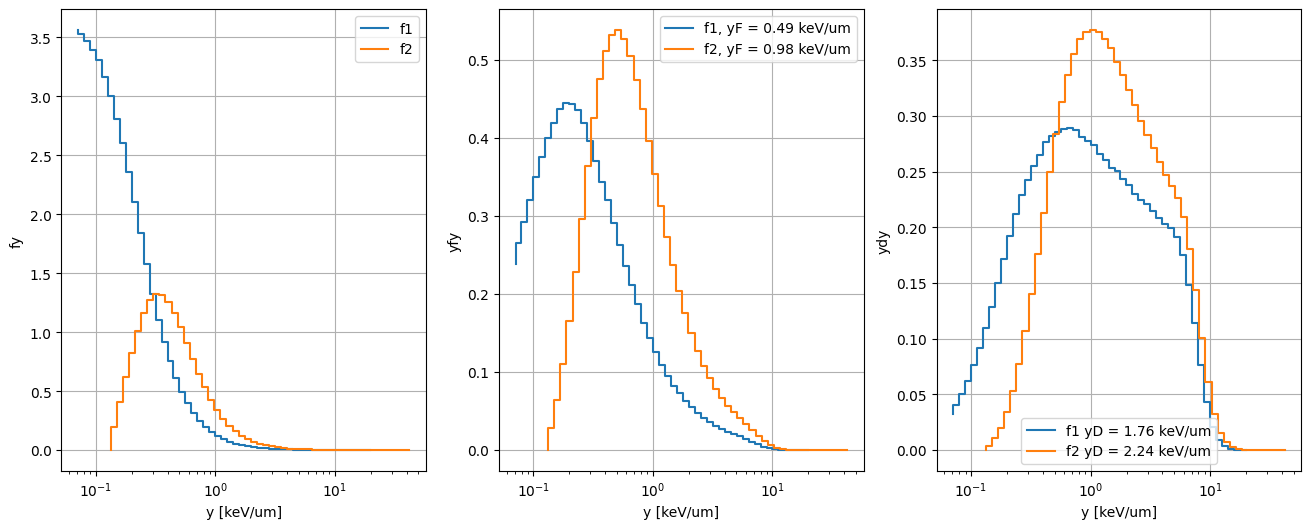

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="f1",
)
ax[0].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.fy,
    label="f2",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label=f"f1, yF = {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.yfy,
    label=f"f2, yF = {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label=f"f1 yD = {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.ydy,
    label=f"f2 yD = {spectrum_y_f2.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f2 z spectrum

In [56]:
spectrum_z_f2 = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=0.204 * spectrum_y_f2.y / site_diam_um**2,
        bin_values_freq=spectrum_y_f2.fy,
    )
)

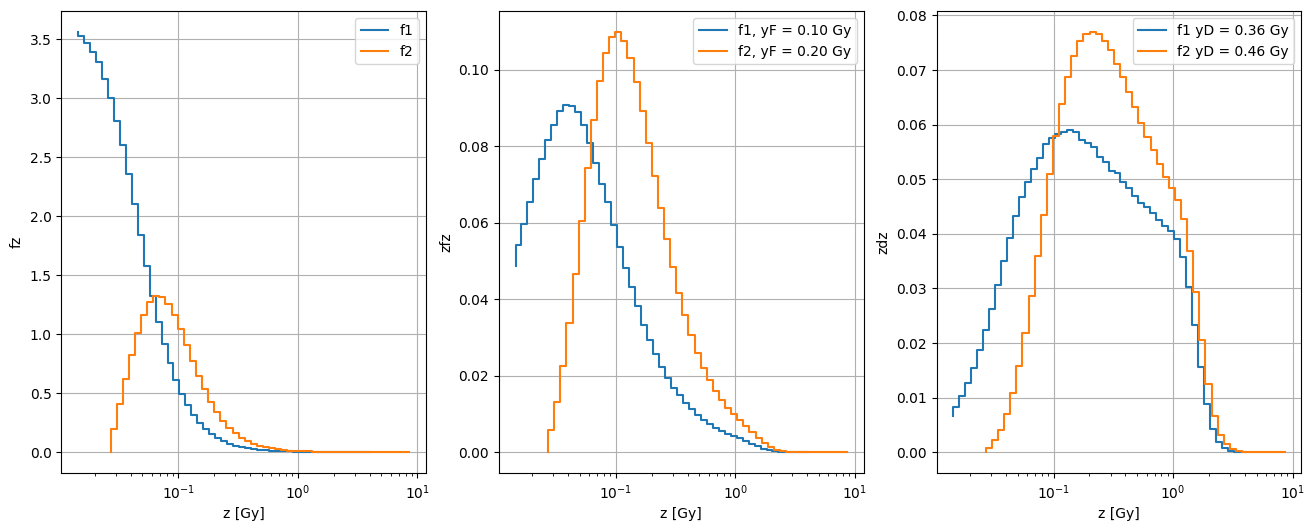

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.fz,
    label="f1",
)
ax[0].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.fz,
    label="f2",
)
ax[0].set_ylabel("fz")
ax[1].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zfz,
    label=f"f1, yF = {spectrum_z_f1.zF:2.2f} Gy",
)
ax[1].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.zfz,
    label=f"f2, yF = {spectrum_z_f2.zF:2.2f} Gy",
)
ax[1].set_ylabel("zfz")
ax[2].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zdz,
    label=f"f1 yD = {spectrum_z_f1.zD:2.2f} Gy",
)
ax[2].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.zdz,
    label=f"f2 yD = {spectrum_z_f2.zD:2.2f} Gy",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

# Dose dependent  z spectra

In [58]:
D_Gy = 0.05  # Gy (50 mGy)
D_Gy

0.05

In [59]:
# mean number of events in the site
n = D_Gy / spectrum_z_f1.zF
n

0.5020742929431895

In [60]:
# In microdosimetry the low dose is the dose at which sensitive site is affected just once.
# However, since the cells are hit independently, even at low doses target can be hit two or
# more times. Therefore, the statistical criterion for low dose is that 90% of the affected targets
# are hit just once. This happens when D ≤ 0.2 zF .

In [61]:
D_Gy, 0.2 * spectrum_z_f1.zF

(0.05, 0.019917371075462563)

In [62]:
# trying to evaluate n f1(z) + n^2/2 f2(z), we are missing here f0(z)
n, n**2 / 2, np.exp(-n)

(0.5020742929431895, 0.12603929781720183, 0.6052738414006829)

In [63]:
z_Gy = np.geomspace(start=1e-3, stop=1e3, num=10000)
spectrum_z_fn_values = n * spectrum_z_f1.data.bin_values(
    z_Gy, spectrum_value_type=SpectrumValueType.fz
) + n**2 / 2 * spectrum_z_f2.data.bin_values(
    z_Gy, spectrum_value_type=SpectrumValueType.fz
)
spectrum_z_fn_values *= np.exp(-n)

In [64]:
spectrum_z_fn_not_normalized = SpecificEnergySpectrum(
    data=SpectrumData(bin_centers=z_Gy, bin_values_freq=spectrum_z_fn_values),
    site_diam_um=spectrum_z_f1.site_diam_um,
)

In [65]:
spectrum_z_fn = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum_z_fn_not_normalized.data.bin_centers,
        bin_values_freq=spectrum_z_fn_not_normalized.data.bin_values_freq,
    ),
    site_diam_um=spectrum_z_fn_not_normalized.site_diam_um,
)

In [66]:
spectrum_z_fn.zF, spectrum_z_fn.zD

(0.1195340177449456, 0.39267101125600434)

In [67]:
spectrum_z_fn.norm

0.0775438985780868

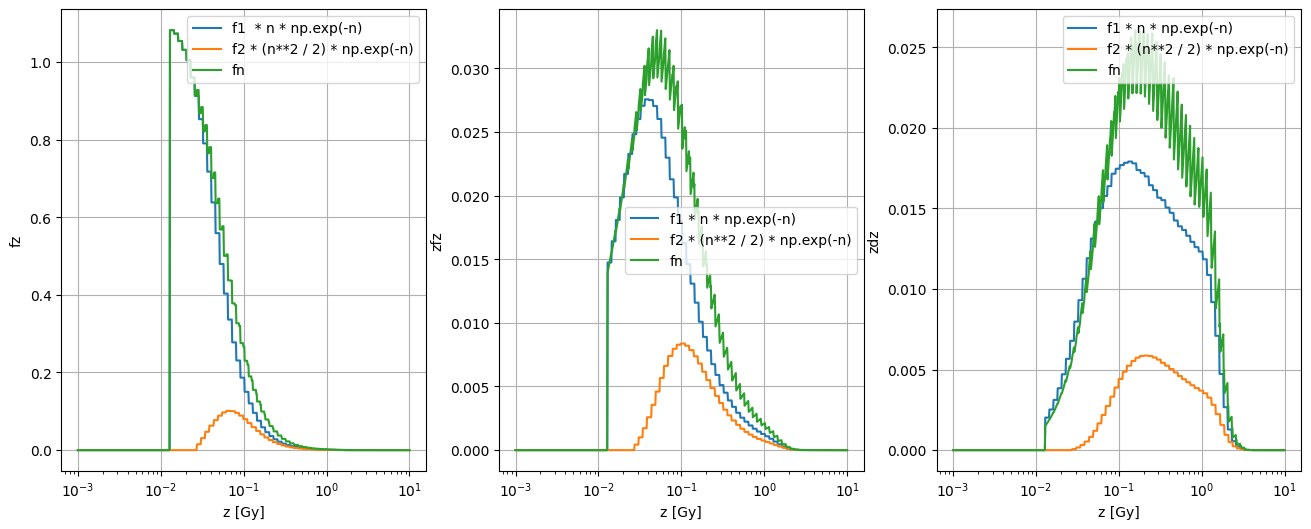

In [68]:
z_Gy = np.geomspace(start=1e-3, stop=10, num=800)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * n
    * np.exp(-n),
    label="f1  * n * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="fn",
)
ax[0].set_ylabel("fz")
ax[1].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * n
    * np.exp(-n),
    label="f1 * n * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz),
    label="fn",
)
ax[1].set_ylabel("zfz")
ax[2].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * n
    * np.exp(-n),
    label="f1 * n * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz),
    label="fn",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

In [69]:
spectrum_z_fn.norm

0.0775438985780868

# Dose dependent y spectra

In [77]:
spectrum_y_fn_notnormalized = lineal_energy_spectum(spectrum_z_fn)
spectrum_y_fn_notnormalized.norm

0.38011714989258244

In [78]:
spectrum_y_fn = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum_y_fn_notnormalized.data.bin_centers,
        bin_values_freq=spectrum_y_fn_notnormalized.data.bin_values_freq
        / spectrum_y_fn_notnormalized.norm,
    )
)
spectrum_y_fn.norm

1.0

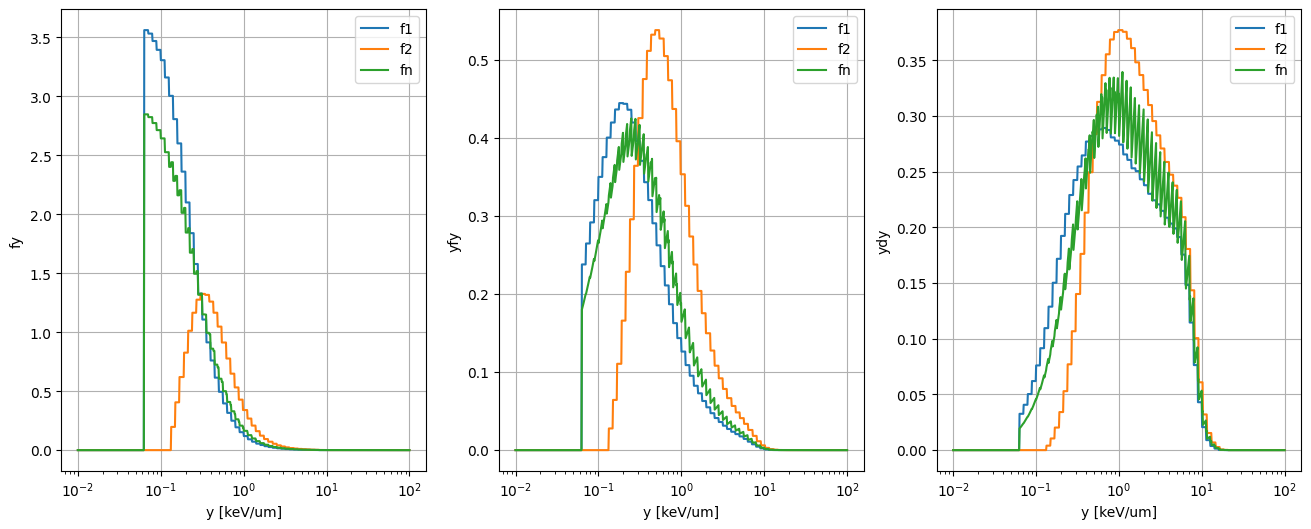

In [83]:
y_keV_um = np.geomspace(start=1e-2, stop=1e2, num=800)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="f1",
)
ax[0].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="f2",
)
ax[0].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="fn",
)
ax[0].set_ylabel("fy")
ax[1].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="f1",
)
ax[1].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="f2",
)
ax[1].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="fn",
)
ax[1].set_ylabel("yfy")
ax[2].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="f1",
)
ax[2].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="f2",
)
ax[2].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="fn",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

In [84]:
spectrum_y_f1.yF, spectrum_y_f2.yF, spectrum_y_fn.yF

(0.48817085969270974, 0.9750110341393071, 0.5859510673771844)

In [90]:
from src.probability import cfds_with_progress

y_keV_um = np.geomspace(start=1e-1, stop=1e1, num=100)
integral_kwargs = {"limit": 2000}
# integral_kwargs = {}
cfds_y_fn_with_errors = cfds_with_progress(
    y_keV_um, spectrum_y_fn.data, include_error=True, kwargs=integral_kwargs
)

Processing: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


(0.9, 1.0445152232566735)

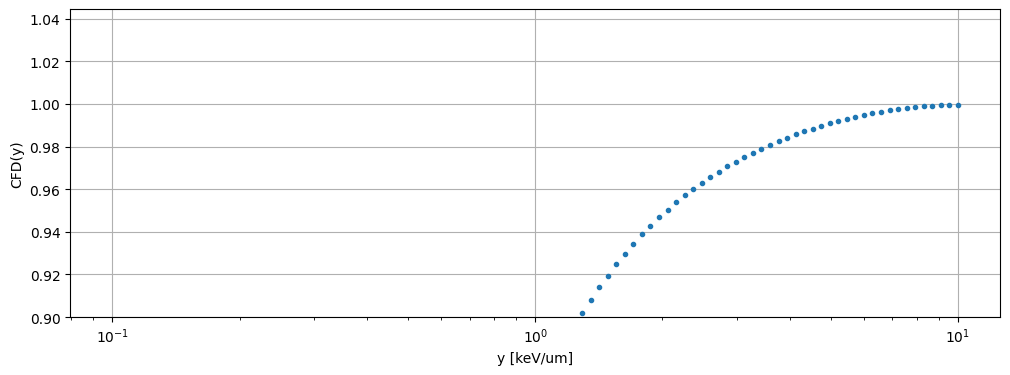

In [92]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.errorbar(
    y_keV_um, cfds_y_fn_with_errors[:, 0], yerr=cfds_y_fn_with_errors[:, 1], fmt="."
)
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("y [keV/um]")
ax.set_ylabel("CFD(y)")
ax.set_ylim(0.9, None)